In [1]:
import numpy as np
import pandas as pd
from fbprophet import Prophet

from sklearn.impute import SimpleImputer

import logging

# Prophet

由facebook開發，專門用於時間序列分析的開源套件，<br>
傳統用於時間序列分析的方法，會有應用範圍侷限、缺失值問題、對專業知識要求多、模型靈活性低，<br>
等等的缺點。<br>
但prophet專注於讓一般人也能做出專業分析師的結果，透過簡單的參數調整做出最適合的分析預測。

<br><br>

prophet將時間序列分析拆分成四個部分：<br>
$y(t) = g(t) + s(t) + h(t) + \epsilon_t$ <br>
* $g(t)$ ： 時間序列終非週期性的**linear**或**logistic**增長變化
* $s(t)$ ： 週期性變化(daily / weekly / yearly 等等)
* $h(t)$ ： 非週期性節日、假日(二二八、黑色星期五等等)
* $\epsilon_t$ ： 誤差項

In [4]:
df = pd.read_csv('./dataset/covid_19_data.csv', parse_dates=['Last Update'])
df.rename(columns = {'ObservationDate' : 'Date',
                     'Province/State' : 'State',
                     'Country/Region' : 'Country'},
          inplace = True
         )

In [19]:
i = 0
nan_state = df['State'].isna()
for is_nan in nan_state :
    if is_nan :
        df.iloc[i, 2] = df.iloc[i, 3]
    i += 1

In [21]:
covid_day_sum = df.groupby('Date').sum()

confirmed = covid_day_sum['Confirmed'].reset_index()
deaths = covid_day_sum['Deaths'].reset_index()
recovered = covid_day_sum['Recovered'].reset_index()

confirmed['Date'] = pd.to_datetime(confirmed['Date'])
deaths['Date'] = pd.to_datetime(deaths['Date'])
recovered['Date'] = pd.to_datetime(recovered['Date'])

In [24]:
logging.getLogger('fbprophet').setLevel(logging.ERROR)

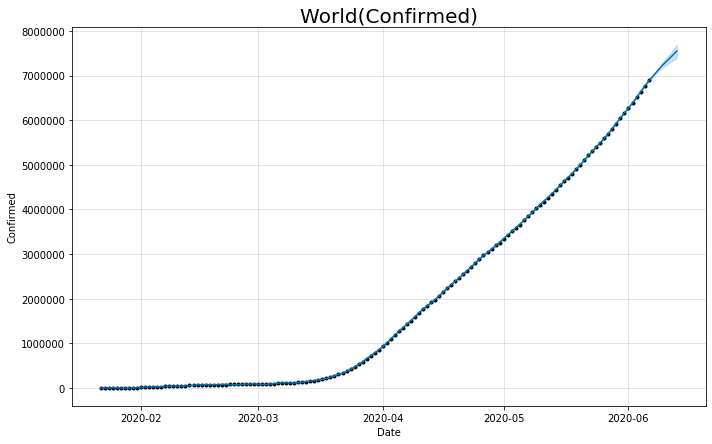

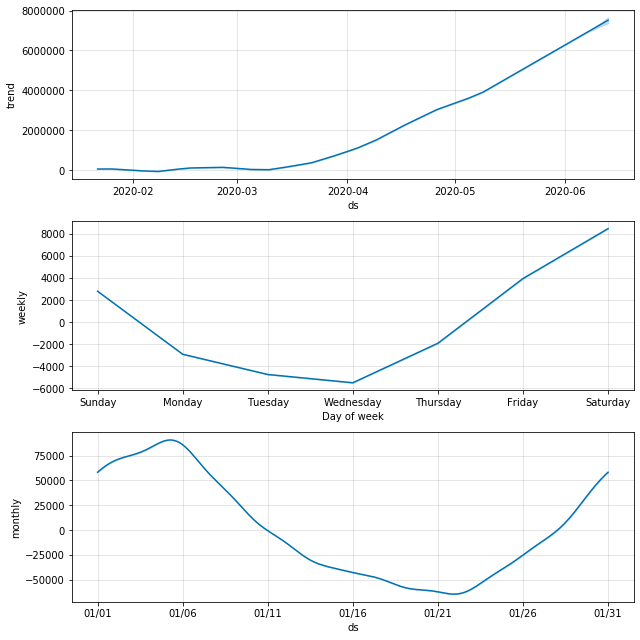

In [77]:
confirmed.rename(columns = {'Date' : 'ds', 'Confirmed' : 'y'},
                 inplace = True)
model = Prophet(interval_width=0.95, yearly_seasonality=False)
model.add_seasonality(name='monthly', period=30.5, fourier_order=10)                      
model.fit(confirmed)
future = model.make_future_dataframe(periods = 7)
forecast = model.predict(future)

fig = model.plot(forecast, xlabel='Date', ylabel='Confirmed');
ax = fig.gca()
ax.set_title('World(Confirmed)', size=20)
model.plot_components(forecast);

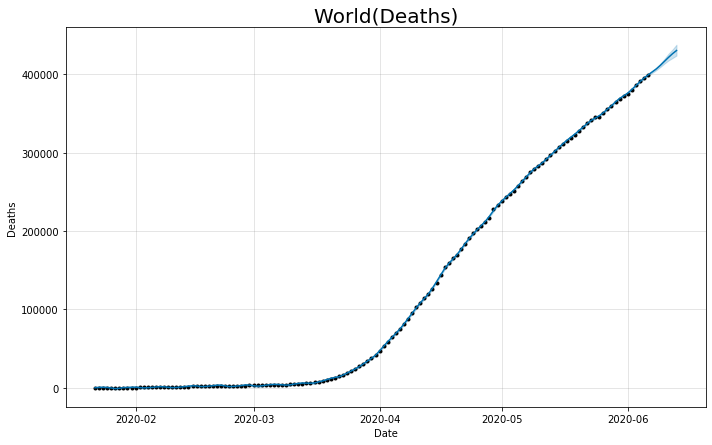

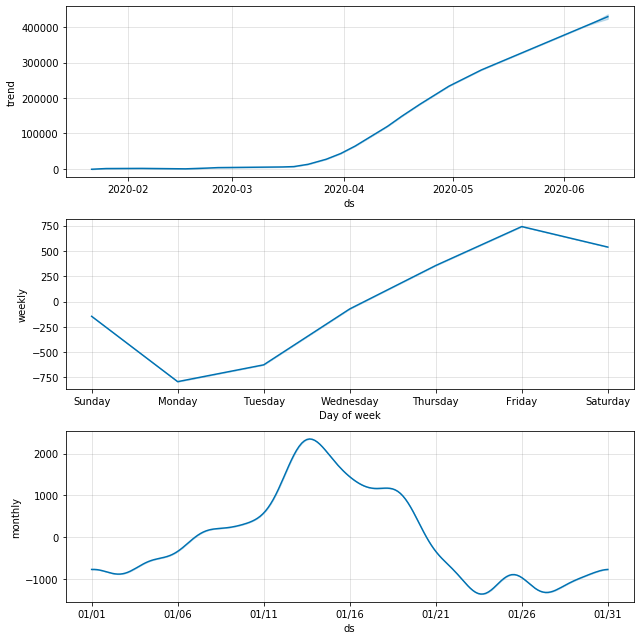

In [78]:
deaths.rename(columns = {'Date' : 'ds', 'Deaths' : 'y'},
                 inplace = True)
model = Prophet(interval_width=0.95, yearly_seasonality=False)
model.add_seasonality(name='monthly', period=30.5, fourier_order=10)  
model.fit(deaths)
future = model.make_future_dataframe(periods = 7)
forecast = model.predict(future)

fig = model.plot(forecast, xlabel='Date', ylabel='Deaths');
ax = fig.gca()
ax.set_title('World(Deaths)', size=20)
model.plot_components(forecast);

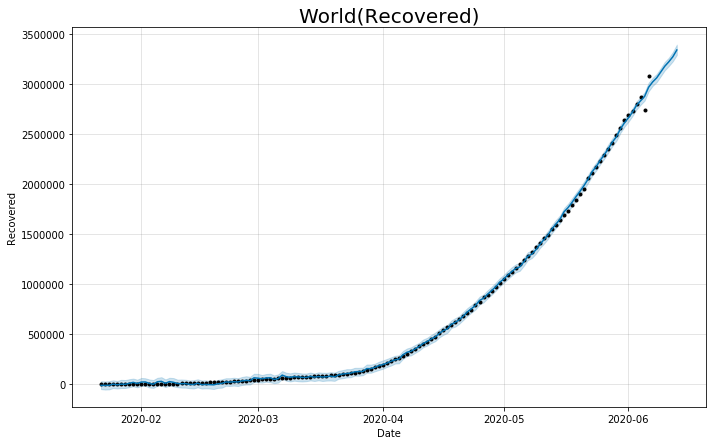

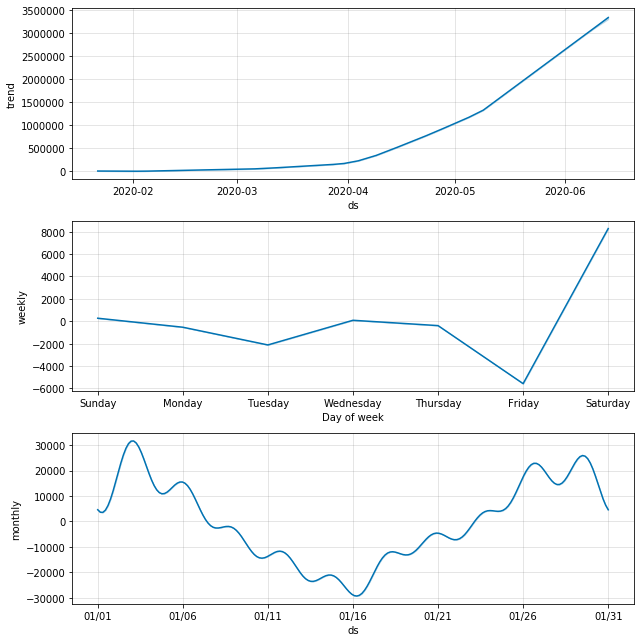

In [79]:
recovered.rename(columns = {'Date' : 'ds', 'Recovered' : 'y'},
                 inplace = True)
model = Prophet(interval_width=0.95, yearly_seasonality=False)
model.add_seasonality(name='monthly', period=30.5, fourier_order=10)  
model.fit(recovered)
future = model.make_future_dataframe(periods = 7)
forecast = model.predict(future)

fig = model.plot(forecast, xlabel='Date', ylabel='Recovered');
ax = fig.gca()
ax.set_title('World(Recovered)', size=20)
model.plot_components(forecast);

E:\Anaconda\lib\site-packages\fbprophet\plot.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(facecolor='w', figsize=figsize)
E:\Anaconda\lib\site-packages\fbprophet\plot.py:146: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(npanel, 1, facecolor='w', figsize=figsize)
E:\Anaconda\lib\site-packages\fbprophet\plot.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume to

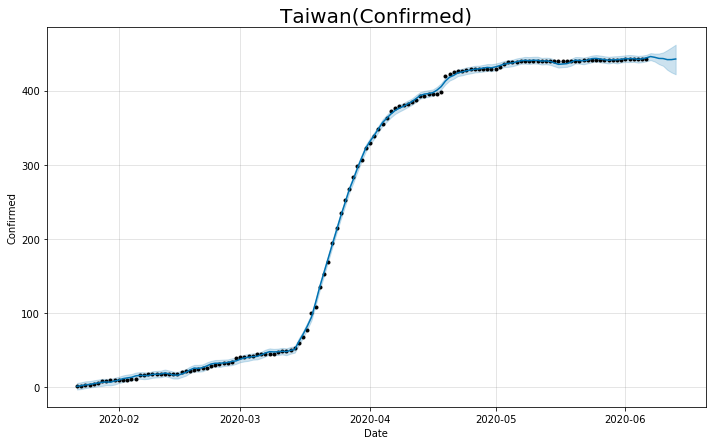

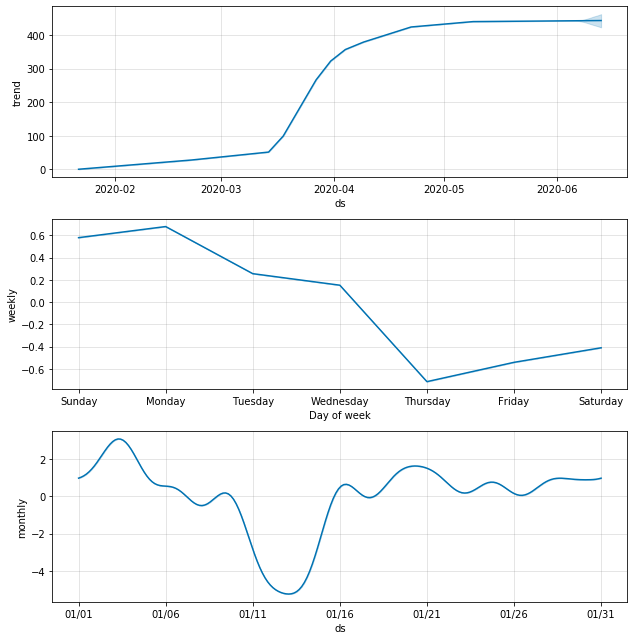

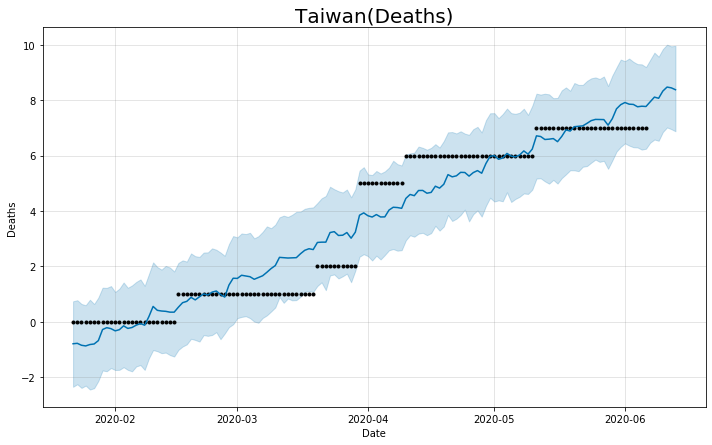

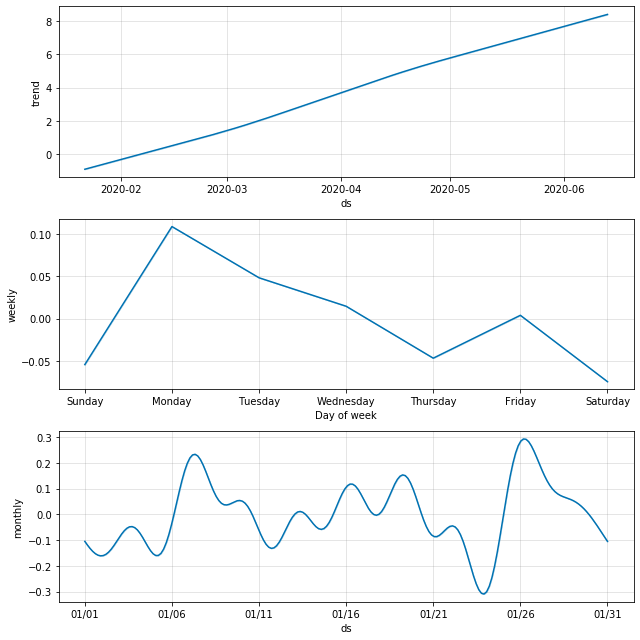

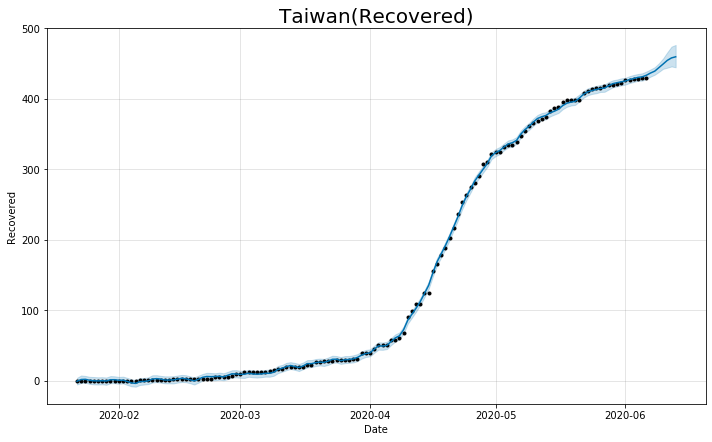

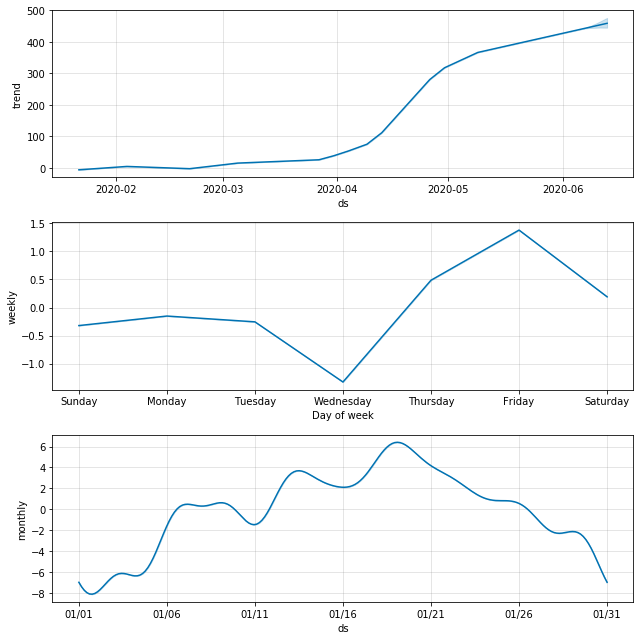

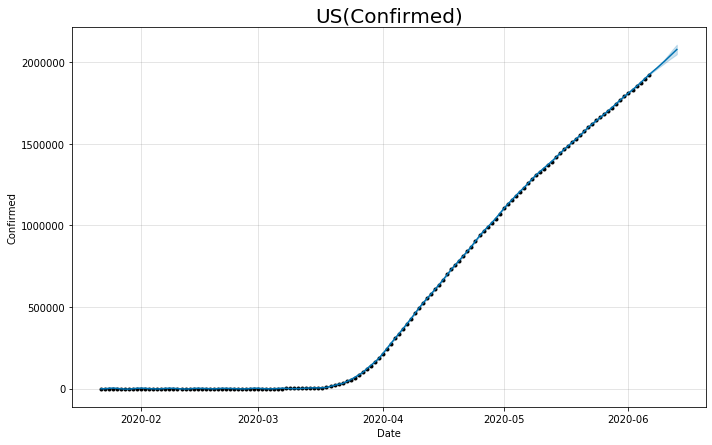

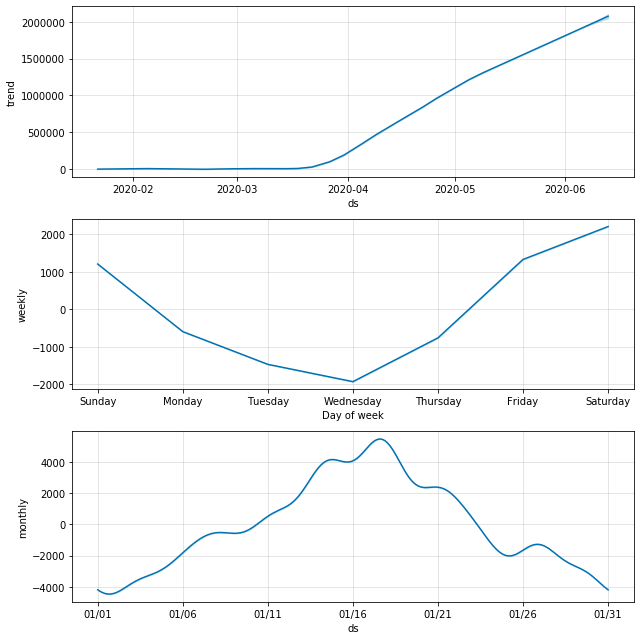

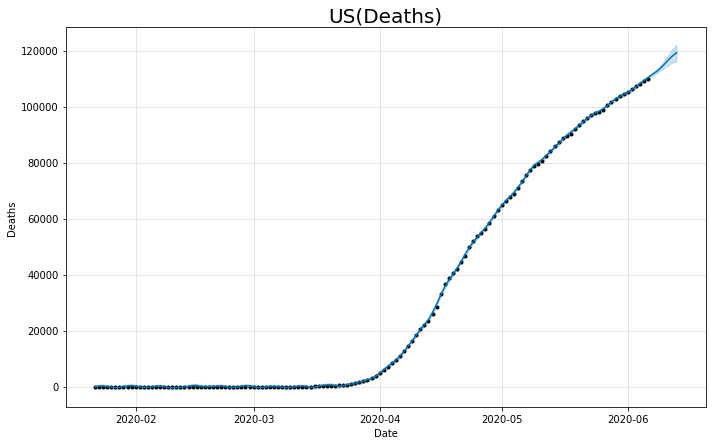

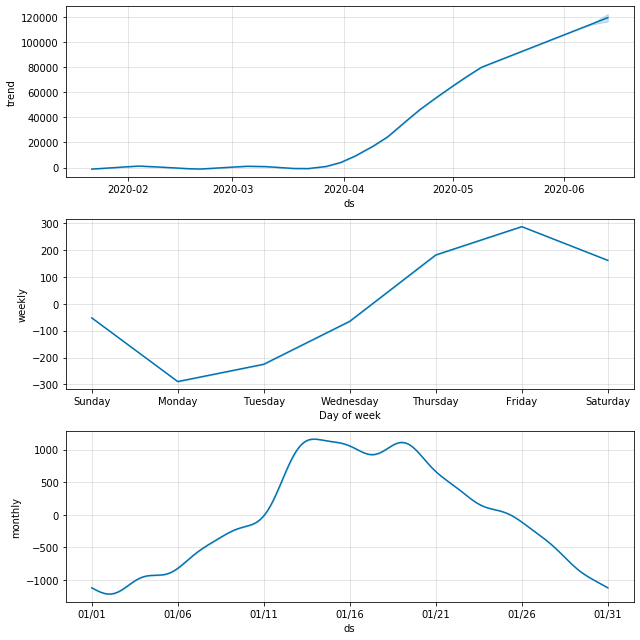

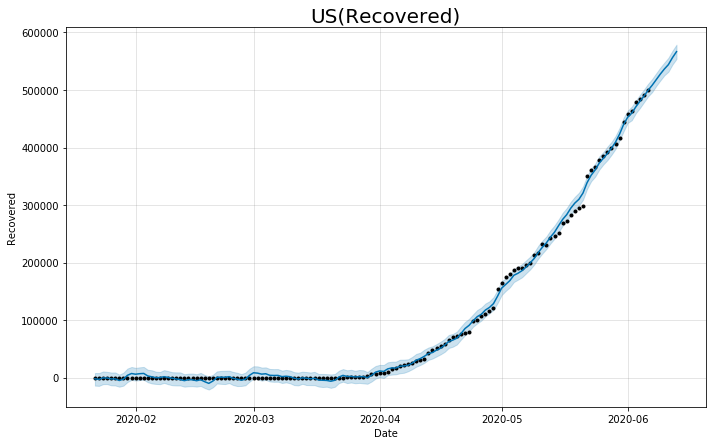

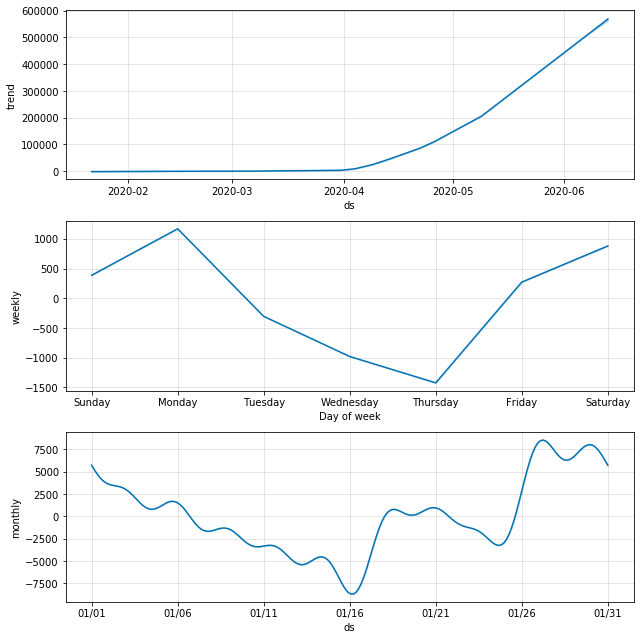

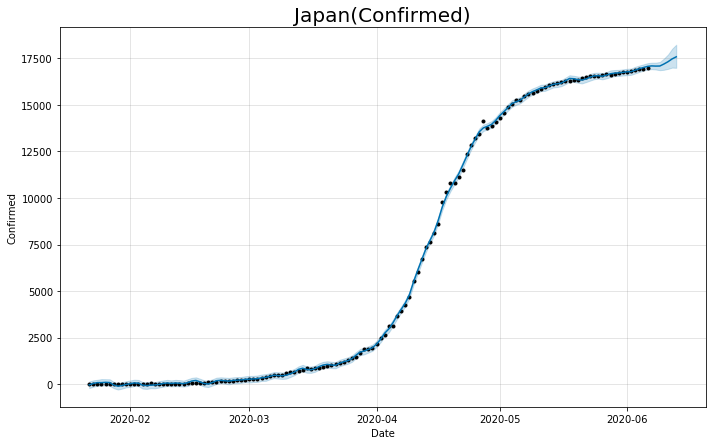

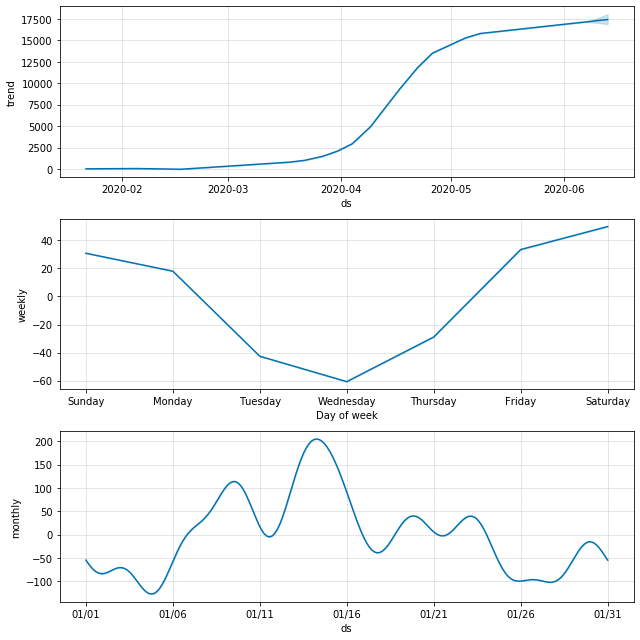

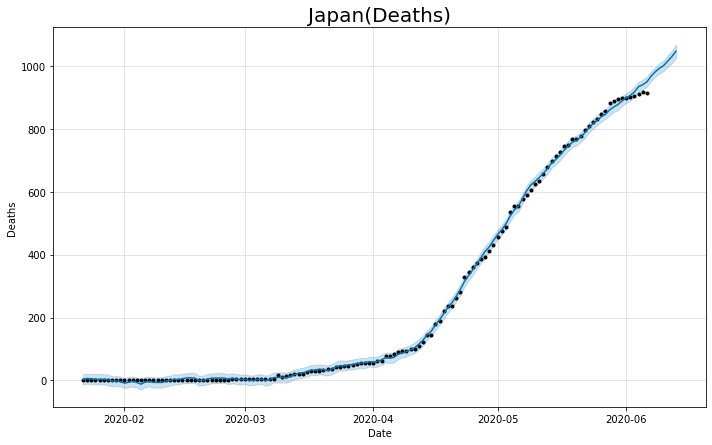

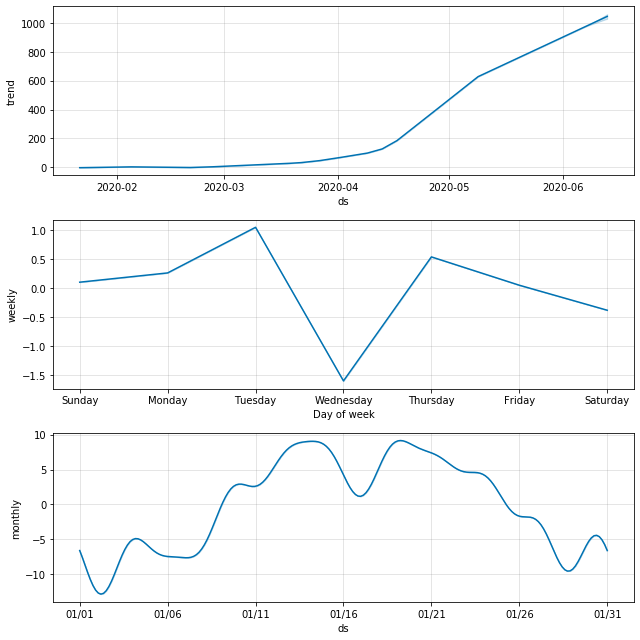

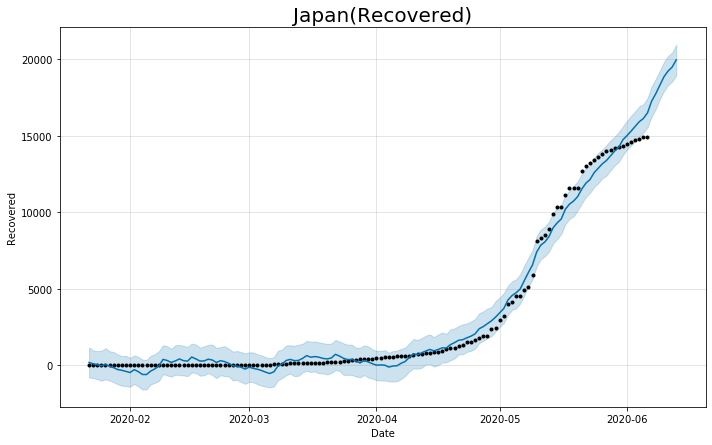

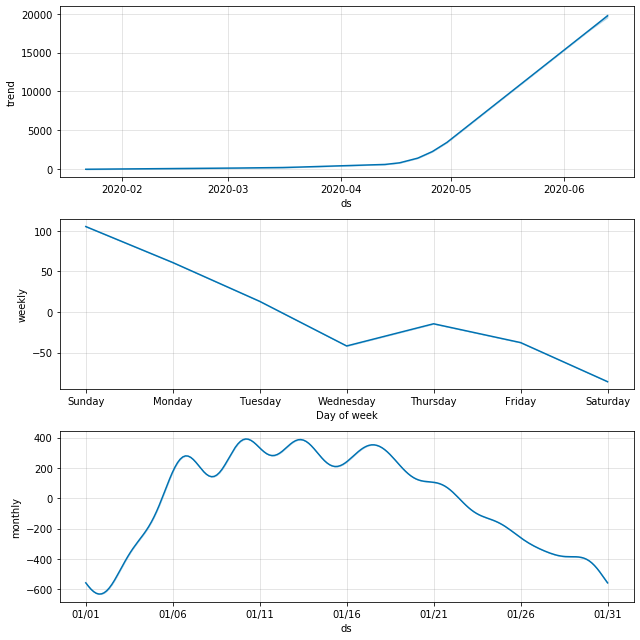

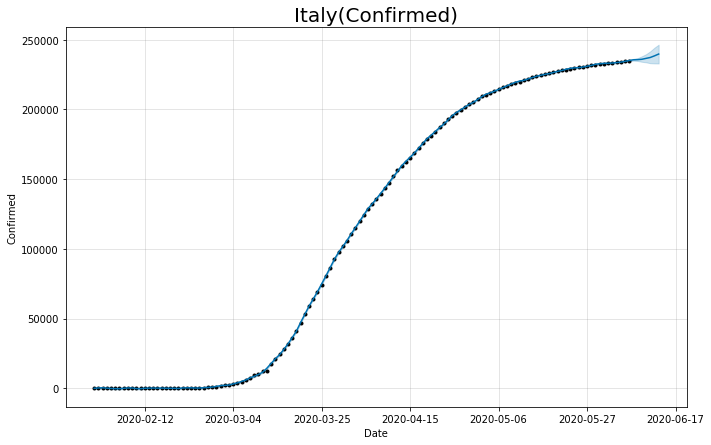

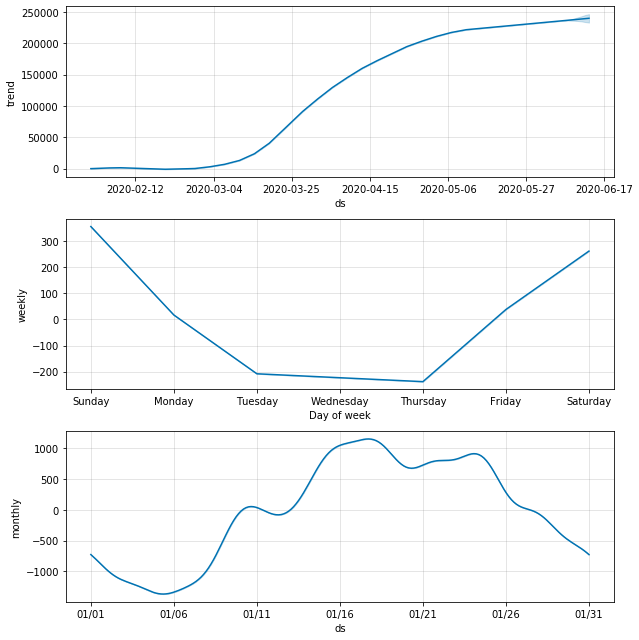

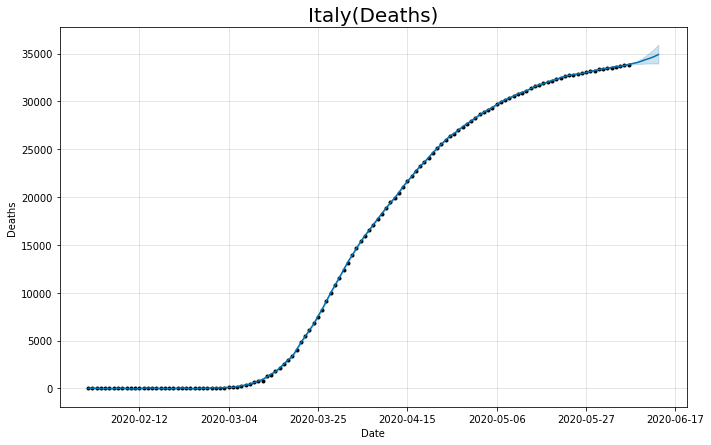

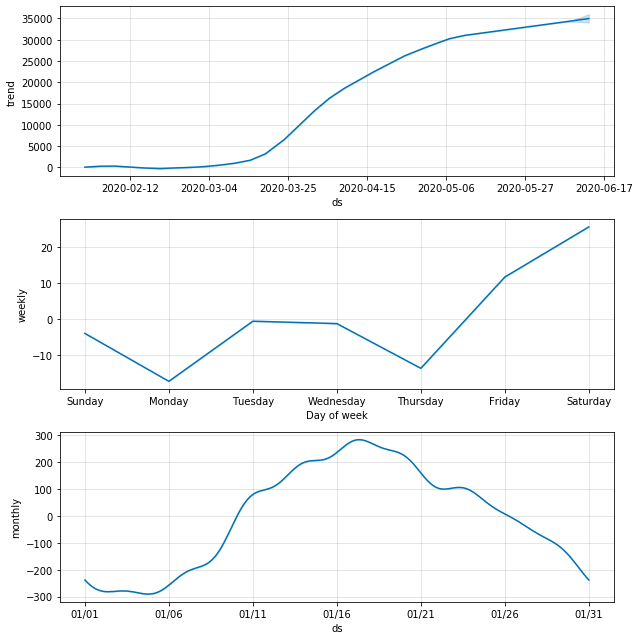

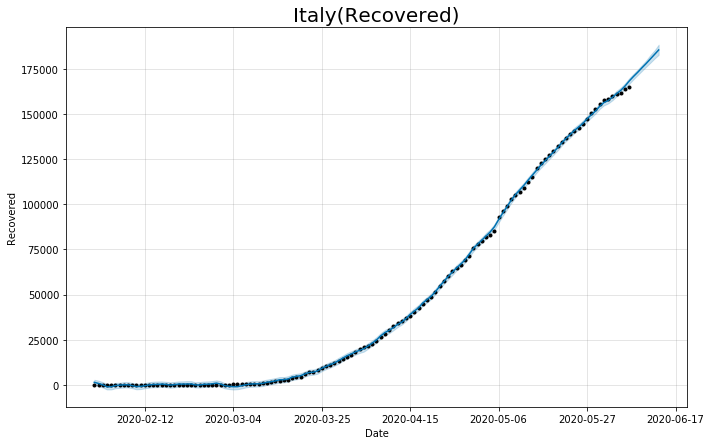

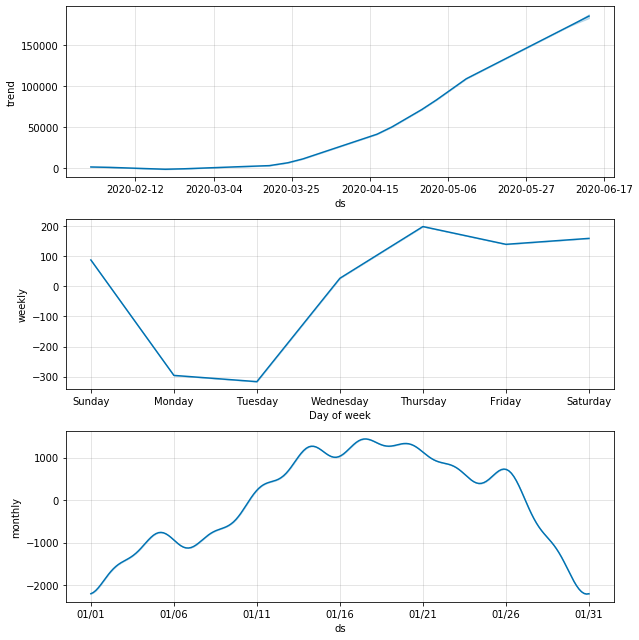

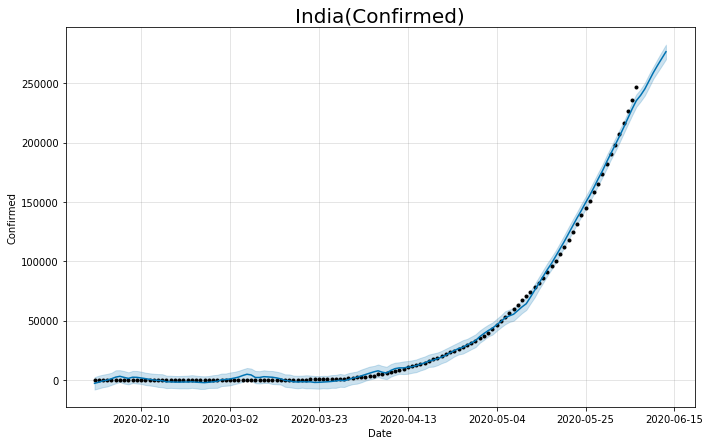

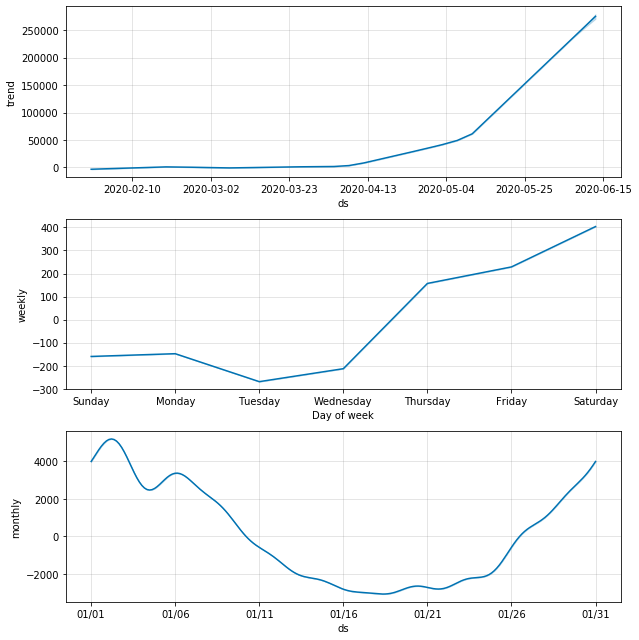

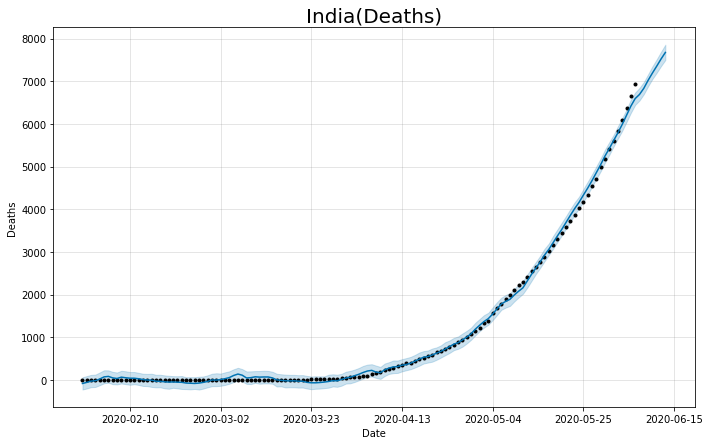

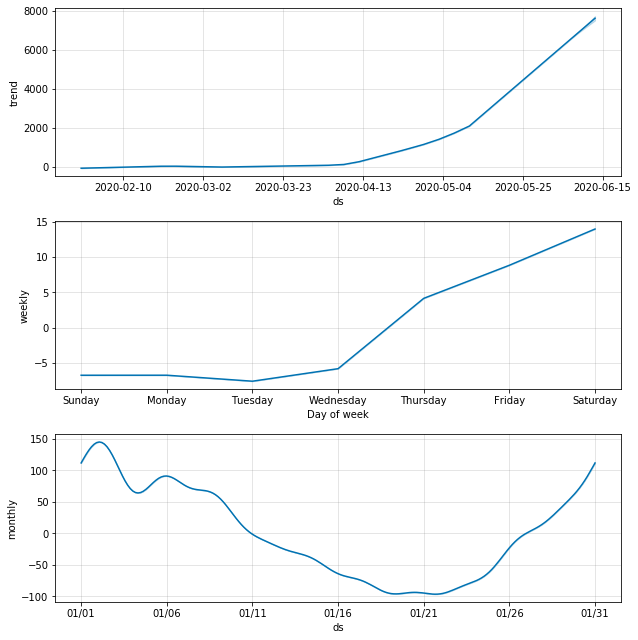

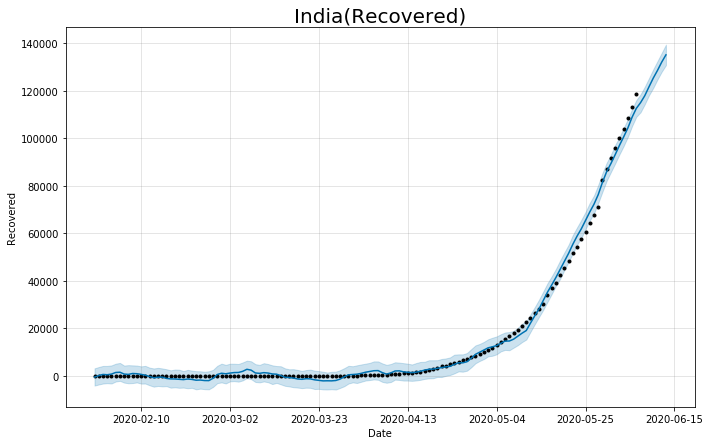

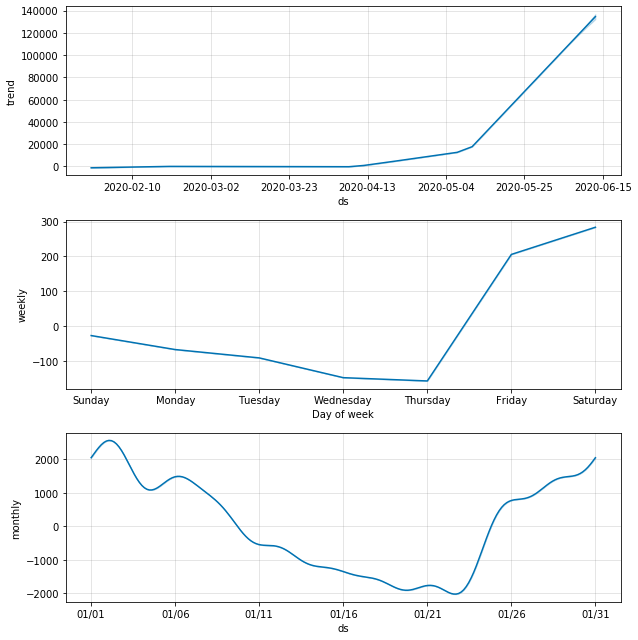

In [76]:
df_cw = df.groupby(['Country', 'Date']).sum()

targets = ['Taiwan', 'US', 'Japan', 'Italy', 'India']
cases = ['Confirmed', 'Deaths', 'Recovered']

for target in targets :
    for case in cases :
        df_c = df_cw.query(f'Country == "{target}"').reset_index()[['Date', case]]
        df_c.rename(columns = {'Date' : 'ds', case : 'y'}, inplace = True)

        model = Prophet(interval_width=0.95, yearly_seasonality=False)
        model.add_seasonality(name='monthly', period=30.5, fourier_order=10)  
        model.fit(df_c)
        future = model.make_future_dataframe(periods = 7)
        forecast = model.predict(future)

        fig = model.plot(forecast, xlabel='Date', ylabel=case)
        ax = fig.gca()
        ax.set_title(f'{target}({case})', size=20)
        model.plot_components(forecast);

In [4]:
df2 = df.groupby(['Date', 'Country', 'State'])[[
    'Date', 'State', 'Country',
    'Confirmed', 'Deaths', 'Recovered'
]].sum().reset_index()

df_confirmed = df2[['Date', 'State', 'Country', 'Confirmed']]
df_deaths = df2[['Date', 'State', 'Country', 'Deaths']]
df_recovered = df2[['Date', 'State', 'Country', 'Recovered']]

countries = df['Country'].unique()

In [5]:
forecast_len = 7
start_day = sorted(df['Date'].unique())[-forecast_len]
start_day = pd.to_datetime(start_day)
forecast_dfs = []
abs_errs = {
    'Confirmed' : [],
    'Deaths' : [],
    'Recovered' : []
}
count = 0

for country in countries :
    count += 1
    print(f'processing...{country}({count}/{len(countries)})')
        
    country_c = df_confirmed[df_confirmed['Country'] == country]
    country_d = df_deaths[df_deaths['Country'] == country]
    country_r = df_recovered[df_recovered['Country'] == country]
    country_info = [
        ('Confirmed', country_c),
        ('Deaths', country_d),
        ('Recovered', country_r)
    ]
    
    states = country_c['State'].unique()
    state_count = 0
    for state in states :
        state_count += 1
        print(f'  on state {state}({state_count}/{len(states)})')
        nice = True
        state_dfs = []
        for country_tuple in country_info :
            case = country_tuple[0]
            dfc = country_tuple[1]
            dfs = dfc[(dfc['State'] == state)]
            
            dfs = dfs[['Date', case]]
            dfs['Date'] = pd.to_datetime(dfs['Date'])
            dfs.rename(columns = {'Date' : 'ds', case : 'y'},
                       inplace = True)
            
            train_df = dfs[dfs['ds'] < start_day]
            valid_df = dfs[dfs['ds'] >= start_day]
            
            if train_df[train_df['y'].notnull()].shape[0] < 2 :
                nice = False
                break
            
            model = Prophet()
            model.fit(train_df)
            future = model.make_future_dataframe(periods = forecast_len)
            forecast = model.predict(future)[['ds', 'yhat']]
            
            train_result = forecast[forecast['ds'] >= start_day]
            cmp_df = train_result.merge(valid_df, on = ['ds'])
            cmp_df['abs_err'] = abs(cmp_df['y'] - cmp_df['yhat'])
            
            abs_errs[case] += list(cmp_df['abs_err'].values)
            forecast['State'] = state
            forecast['Country'] = country
            forecast.rename(columns = {'yhat' : case}, inplace = True)
            
            state_dfs += [forecast.tail(forecast_len)]
        
        if not nice : continue
        
        df_st = state_dfs[0].merge(state_dfs[1],
                                   on = ['ds', 'State', 'Country'])
        df_st = df_st.merge(state_dfs[2],
                            on = ['ds', 'State', 'Country'])
        forecast_dfs += [df_st]

processing...Mainland China(1/223)
  on state Anhui(1/31)


INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


  on state Beijing(2/31)
  on state Chongqing(3/31)
  on state Fujian(4/31)
  on state Gansu(5/31)
  on state Guangdong(6/31)
  on state Guangxi(7/31)
  on state Guizhou(8/31)
  on state Hainan(9/31)
  on state Hebei(10/31)
  on state Heilongjiang(11/31)
  on state Henan(12/31)
  on state Hubei(13/31)
  on state Hunan(14/31)
  on state Inner Mongolia(15/31)
  on state Jiangsu(16/31)
  on state Jiangxi(17/31)
  on state Jilin(18/31)
  on state Liaoning(19/31)
  on state Ningxia(20/31)
  on state Qinghai(21/31)
  on state Shaanxi(22/31)
  on state Shandong(23/31)
  on state Shanghai(24/31)
  on state Shanxi(25/31)
  on state Sichuan(26/31)
  on state Tianjin(27/31)
  on state Tibet(28/31)
  on state Xinjiang(29/31)
  on state Yunnan(30/31)
  on state Zhejiang(31/31)
processing...Hong Kong(2/223)
  on state Hong Kong(1/1)
processing...Macau(3/223)
  on state Macau(1/1)
processing...Taiwan(4/223)
  on state Taiwan(1/2)
  on state Diamond Princess cruise ship(2/2)
processing...US(5/223)
  o

  on state Aichi(2/49)
  on state Akita(3/49)
  on state Aomori(4/49)
  on state Chiba(5/49)
  on state Ehime(6/49)
  on state Fukui(7/49)
  on state Fukuoka(8/49)
  on state Fukushima(9/49)
  on state Gifu(10/49)
  on state Gunma(11/49)
  on state Hiroshima(12/49)
  on state Hokkaido(13/49)
  on state Hyogo(14/49)
  on state Ibaraki(15/49)
  on state Ishikawa(16/49)
  on state Kagawa(17/49)
  on state Kagoshima(18/49)
  on state Kanagawa(19/49)
  on state Kochi(20/49)
  on state Kumamoto(21/49)
  on state Kyoto(22/49)
  on state Mie(23/49)
  on state Miyagi(24/49)
  on state Miyazaki(25/49)
  on state Nagano(26/49)
  on state Nagasaki(27/49)
  on state Nara(28/49)
  on state Niigata(29/49)
  on state Oita(30/49)
  on state Okayama(31/49)
  on state Okinawa(32/49)
  on state Osaka(33/49)
  on state Port Quarantine(34/49)
  on state Saga(35/49)
  on state Saitama(36/49)
  on state Shiga(37/49)
  on state Shimane(38/49)
  on state Shizuoka(39/49)
  on state Tochigi(40/49)
  on state Toku

  on state Falkland Islands (Islas Malvinas)(13/14)
  on state Falkland Islands (Malvinas)(14/14)
processing...Russia(29/223)
  on state Diamond Princess cruise ship(1/84)
  on state Adygea Republic(2/84)
  on state Altai Krai(3/84)
  on state Altai Republic(4/84)
  on state Amur Oblast(5/84)
  on state Arkhangelsk Oblast(6/84)
  on state Astrakhan Oblast(7/84)
  on state Bashkortostan Republic(8/84)
  on state Belgorod Oblast(9/84)
  on state Bryansk Oblast(10/84)
  on state Buryatia Republic(11/84)
  on state Chechen Republic(12/84)
  on state Chelyabinsk Oblast(13/84)
  on state Chukotka Autonomous Okrug(14/84)
  on state Chuvashia Republic(15/84)
  on state Dagestan Republic(16/84)
  on state Ingushetia Republic(17/84)
  on state Irkutsk Oblast(18/84)
  on state Ivanovo Oblast(19/84)
  on state Jewish Autonomous Okrug(20/84)
  on state Kabardino-Balkarian Republic(21/84)
  on state Kaliningrad Oblast(22/84)
  on state Kalmykia Republic(23/84)
  on state Kaluga Oblast(24/84)
  on st

processing...Senegal(79/223)
  on state Diamond Princess cruise ship(1/1)
processing...Argentina(80/223)
  on state Diamond Princess cruise ship(1/1)
processing...Chile(81/223)
  on state Diamond Princess cruise ship(1/18)
  on state Antofagasta(2/18)
  on state Araucania(3/18)
  on state Arica y Parinacota(4/18)
  on state Atacama(5/18)
  on state Aysen(6/18)
  on state Biobio(7/18)
  on state Coquimbo(8/18)
  on state Los Lagos(9/18)
  on state Los Rios(10/18)
  on state Magallanes(11/18)
  on state Maule(12/18)
  on state Metropolitana(13/18)
  on state Nuble(14/18)
  on state OHiggins(15/18)
  on state Tarapaca(16/18)
  on state Unknown(17/18)
  on state Valparaiso(18/18)
processing...Jordan(82/223)
  on state Diamond Princess cruise ship(1/1)
processing...Ukraine(83/223)
  on state Diamond Princess cruise ship(1/28)
  on state Cherkasy Oblast(2/28)
  on state Chernihiv Oblast(3/28)
  on state Chernivtsi Oblast(4/28)
  on state Crimea Republic*(5/28)
  on state Dnipropetrovsk Oblas

processing...Congo (Brazzaville)(159/223)
  on state Diamond Princess cruise ship(1/1)
processing...Equatorial Guinea(160/223)
  on state Diamond Princess cruise ship(1/1)
processing...Uzbekistan(161/223)
  on state Diamond Princess cruise ship(1/1)
processing...Guam(162/223)
  on state Diamond Princess cruise ship(1/1)
processing...Puerto Rico(163/223)
  on state Diamond Princess cruise ship(1/1)
processing...Benin(164/223)
  on state Diamond Princess cruise ship(1/1)
processing...Greenland(165/223)
  on state Diamond Princess cruise ship(1/1)
processing...Liberia(166/223)
  on state Diamond Princess cruise ship(1/1)
processing...Mayotte(167/223)
  on state Diamond Princess cruise ship(1/1)
processing...Republic of the Congo(168/223)
  on state Diamond Princess cruise ship(1/1)
processing...Somalia(169/223)
  on state Diamond Princess cruise ship(1/1)
processing...Tanzania(170/223)
  on state Diamond Princess cruise ship(1/1)
processing...The Bahamas(171/223)
  on state Diamond Prince

In [6]:
confirmed_mae = sum(abs_errs['Confirmed'])/len(abs_errs['Confirmed'])
deaths_mae = sum(abs_errs['Deaths'])/len(abs_errs['Deaths'])
recovered_mae = sum(abs_errs['Recovered'])/len(abs_errs['Recovered'])

print(
    f'Confirmed MAE = {confirmed_mae}\n'
    f'Deaths MAE = {deaths_mae}\n'
    f'Recovered MAE = {recovered_mae}\n'
)

Confirmed MAE = 522.5241184279816
Deaths MAE = 20.518466496867546
Recovered MAE = 642.9614372751389

